In [2]:
%load_ext autoreload
%autoreload 2

In [378]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json

import environment
from filter_synthesis import gf_synth, solve_ft_weights, direct_param
from plain_SLS import sls_synth
import robust
from utils import H2norm, constructSS, computeDelta, achieved_Phi, compute_cost

In [363]:
plt.style.use('seaborn-deep')
plt.rcParams.update({
    'text.usetex': False
})
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 15})

## 1. Graph Shift Operator parameterization vs. SLS parameterization

593.2586823907714


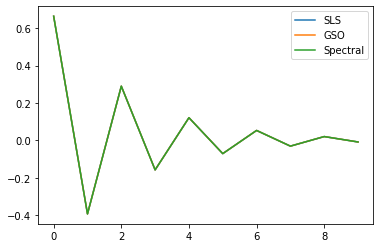

In [4]:
N = 10
degree = 5
T = 10

# Generate environment
G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
x0 = np.random.random(N)
inds = np.arange(0, N*T, N)

# Synthesize controllers
_, _, Phi_x, Phi_u, _, _ = sls_synth(Q, R, A, B, S, T)
_, _, Phi_xd, Phi_ud, _, _ = direct_param(Q, R, A, B, S, T)
_, _, Phi_xs, Phi_us, _, _ = gf_synth(Q, R, A, B, S, T)

# Simulate trajectory forward
xtraj, utraj = environment.get_traj(Phi_x, Phi_u, x0)
xtrajd, utrajd = environment.get_traj(Phi_xd, Phi_ud, x0)
xtrajs, utrajs = environment.get_traj(Phi_xs, Phi_us, x0)
plt.plot(np.arange(T), xtraj[inds])
plt.plot(np.arange(T), xtrajd[inds])
plt.plot(np.arange(T), xtrajs[inds])
_ = plt.legend(['SLS', 'GSO', 'Spectral'])

### Filter weights vs. number of hops

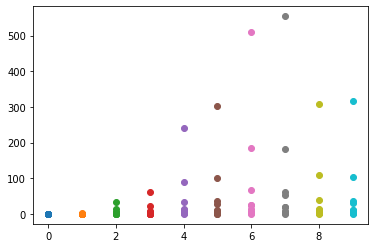

In [5]:
# Solve for filter weights from the Vandermonde matrix
h, Phi = solve_ft_weights(Phi_x, S, None)
for k in range(N):
    plt.scatter(np.ones(T)*k, np.abs(h[:, k]))

## 2. Computing Controllers from $\Phi_x$ and $\Phi_u$
Basically, testing the environment.get_traj_rob function, which computes $\Phi_u\Phi_x^{-1}$

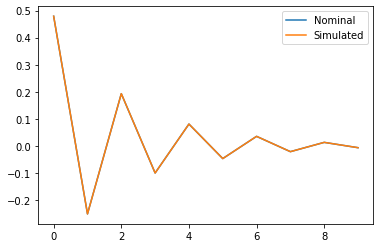

In [6]:
x0 = np.random.random(N)

# Plot the nominal SLS trajectory
xtraj, utraj = environment.get_traj(Phi_x, Phi_u, x0)
plt.plot(np.arange(T), xtraj[inds])

# Plot the trajectory achieved from simulation
Tsim = T
xtraj_sim, u_traj_sim = environment.get_traj_rob(A, B, Phi_x, Phi_u, x0, Tsim)
plt.plot(np.arange(T), xtraj_sim[:, 0])

plt.legend(['Nominal', 'Simulated'])

## 3. Robust SLS *without actually truncating*

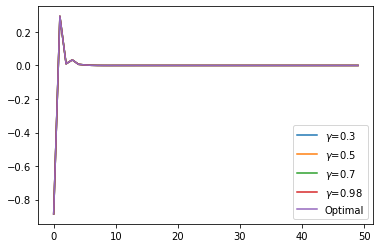

In [7]:
N = 6
degree = 3
T = 5
Tsim = 50
G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
x0 = np.random.normal(0,1,N)

# Synthesize globally optimal controller
_, _, Phi_x, Phi_u, phi_x, phi_u = gf_synth(Q, R, A, B, S, T)

# Synthesize and plot controllers from robust SLS
num_hops = N
gammas = [0.3, 0.5, 0.7, 0.98]
for gamma in gammas:
    _, cost_r, Phi_xr, Phi_ur, _, _, Hbar = robust.robust_synth_gamma(Q, R, A, B, S, T, gamma, num_hops)
    xtraj, utraj = environment.get_traj_rob(A, B, Phi_xr, Phi_ur, x0, Tsim)
    plt.plot(np.arange(Tsim), xtraj[:, 0])

# Plot the optimal controller trajectory
xtrajd, utrajd = environment.get_traj_rob(A, B, Phi_x, Phi_u, x0, Tsim)
plt.plot(np.arange(Tsim), xtraj[:, 0])

_ = plt.legend([r'$\gamma$={}'.format(gamma) for gamma in gammas] + ['Optimal'])

## 5. Truncation Experiment

In [414]:
####################################
experiment_name = 'trunc10_main'
# Graph params
N = 10
degree = 3
# Synthesis params
gamma = 0.98
T = 10
T_opt = 50
# Experiment params
num_envs = 50
hops = [3,4,5,6,7,8,9,10]
####################################

np.random.seed(2022)

cost_robust = np.zeros((num_envs, len(hops)))
cost_proj = np.zeros((num_envs, len(hops)))
cost_rob_proj = np.zeros((num_envs, len(hops)))
cost_opt = np.zeros(num_envs)

for env in range(num_envs):
    print('Environment {},\t hop:'.format(env), end=' ')
    G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
    
    # Compute optimal cost
    _, J_opt, _, _, _, _ = gf_synth(Q, R, A, B, S, T_opt)
    cost_opt[env] = J_opt
    
    # Truncations
    for h, num_hops in enumerate(hops):
        print(num_hops, end=',')
        
        # Truncation via robust SLS
        feas, _, Phi_xr, Phi_ur, _, _, _ = robust.robust_nominal_SLS(Q, R, A, B, S, T, gamma, num_hops)
        if feas:
            cost_robust[env, h] = compute_cost(A, B, Phi_xr, Phi_ur, T)
        else:
            cost_robust[env, h] = np.inf
            
        # Truncation via naive projection
        _, _, Px, Pu, _, _ = gf_synth(Q, R, A, B, S, T) # "Optimal" response to project from
        _, Phi_x_proj = solve_ft_weights(Px, S, num_hops)
        _, Phi_u_proj = solve_ft_weights(Pu, S, num_hops)
        cost_proj[env, h] = compute_cost(A, B, Phi_x_proj, Phi_u_proj, T)
        
        # Truncation via robust projection
        feas, _, Phi_xrp, Phi_urp, _, _, _ = robust.robust_projection(Px, Pu, A, B, S, T, gamma, num_hops)
        if feas:
            cost_rob_proj[env, h] = compute_cost(A, B, Phi_xrp, Phi_urp, T)
        else:
            cost_rob_proj[env, h] = np.inf
        
    print()

# Save data
cost_dict = {
    'num_envs': num_envs,
    'hops': hops,
    'robust': cost_robust.flatten().tolist(),
    'proj': cost_proj.flatten().tolist(),
    'rob_proj': cost_rob_proj.flatten().tolist(),
    'opt': cost_opt.flatten().tolist()
}
with open('./results/' + experiment_name + '.txt','w') as f:
    f.write(json.dumps(cost_dict))

Environment 0,	 hop: 3,

/home/fengjun/Documents/robust-gnn-sls/utils.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.trace(C @ P @ C.T))


4,5,6,7,8,9,10,
Environment 1,	 hop: 3,4,5,6,7,8,9,10,
Environment 2,	 hop: 3,4,5,6,7,8,9,10,
Environment 3,	 hop: 3,4,

/home/fengjun/.virtualenvs/general/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


5,6,7,8,9,10,
Environment 4,	 hop: 3,4,5,6,7,8,9,10,
Environment 5,	 hop: 3,4,5,6,7,8,9,10,
Environment 6,	 hop: 3,4,5,6,7,8,9,10,
Environment 7,	 hop: 3,4,5,6,7,8,9,10,
Environment 8,	 hop: 3,4,5,6,7,8,9,10,
Environment 9,	 hop: 3,4,5,6,7,8,9,10,
Environment 10,	 hop: 3,4,5,6,7,8,9,10,
Environment 11,	 hop: 3,4,5,6,7,8,9,10,
Environment 12,	 hop: 3,4,5,6,7,8,9,10,
Environment 13,	 hop: 3,4,5,6,7,8,9,10,
Environment 14,	 hop: 3,4,5,6,7,8,9,10,
Environment 15,	 hop: 3,4,5,6,7,8,9,10,
Environment 16,	 hop: 3,4,5,6,7,8,9,10,
Environment 17,	 hop: 3,4,5,6,7,8,9,10,
Environment 18,	 hop: 3,4,5,6,7,8,9,10,
Environment 19,	 hop: 3,4,5,6,7,8,9,10,
Environment 20,	 hop: 3,4,5,6,7,8,9,10,
Environment 21,	 hop: 3,4,5,6,7,8,9,10,
Environment 22,	 hop: 3,4,5,6,7,8,9,10,
Environment 23,	 hop: 3,4,5,6,7,8,9,10,
Environment 24,	 hop: 3,4,5,6,7,8,9,10,
Environment 25,	 hop: 3,4,5,6,7,8,9,10,
Environment 26,	 hop: 3,4,5,6,7,8,9,10,
Environment 27,	 hop: 3,4,5,6,7,8,9,10,
Environment 28,	 hop: 3,4,5,6,7,

In [426]:
import networkx as nx
d_total = 0
np.random.seed(2022)
for env in range(num_envs):
    G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
    d_total += nx.diameter(G)
d_avg = d_total / num_envs

In [445]:
# replace np.inf with large number for plotting purposes
cost_robust[cost_robust == np.inf] = 1e6
cost_rob_proj[cost_rob_proj == np.inf] = 1e6

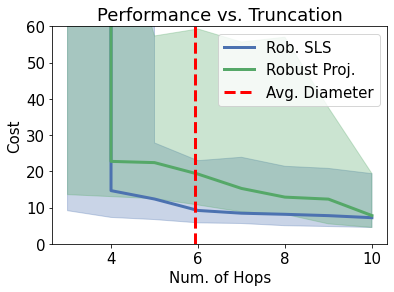

In [467]:
# Plot cost decrease
filename = 'performance_10_main'
costs = [cost_robust, cost_rob_proj]
names = ['Rob. SLS', 'Robust Proj.']
ci_percent = 0.25
for i, cost in enumerate(costs):
    med = np.median(cost, 0)
    p = plt.plot(hops, med, label=names[i], linewidth=3)
    color = p[0].get_color()
    lower_ci = np.quantile(cost, 1-ci_percent, axis=0)
    upper_ci = np.quantile(cost, ci_percent, axis=0)
    plt.fill_between(hops, lower_ci, upper_ci, color=color, alpha=0.3)
# draw vertical line at average diameter
plt.axvline(d_avg, linewidth=3, color='red', linestyle='--', label='Avg. Diameter')
plt.ylim([0, 60])
plt.legend()
plt.title('Performance vs. Truncation')
plt.xlabel('Num. of Hops')
plt.ylabel('Cost')
plt.savefig(filename, dpi=200, format='pdf', bbox_inches="tight")

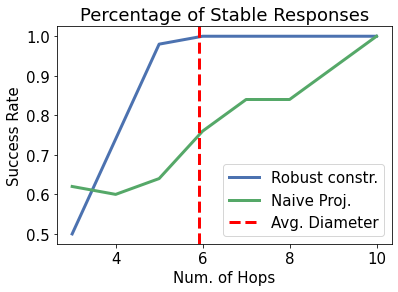

In [466]:
# Plot the percentage of points that are feasible
filename = 'percentage_10_main'
costs = [cost_robust, cost_proj]
names = ['Robust constr.', 'Naive Proj.']
plot_eps = 0.2
for i, cost in enumerate(costs):
    num_feas = (cost < inf_surrogate).mean(0)
    plt.plot(hops, num_feas, label=names[i], linewidth=3)

plt.axvline(d_avg, linewidth=3, color='red', linestyle='--', label='Avg. Diameter')
plt.legend()
plt.title('Percentage of Stable Responses')
plt.xlabel('Num. of Hops')
plt.ylabel('Success Rate')
plt.savefig(filename, dpi=200, format='pdf', bbox_inches="tight")

Text(0, 0.5, 'Cost')

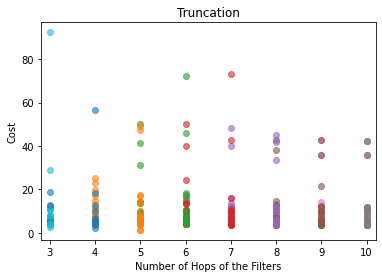

In [322]:
# Scatter plot
plot_eps = 0.2
# Robust SLS approach
for i in range(len(hops)):
    points = cost_robust[:,i]
    feas_points = points[points < 1e6]
    plt.scatter(np.ones(len(feas_points))*hops[i], feas_points, alpha=0.6)
plt.scatter(np.ones(num_envs)*N, cost_opt, alpha=0.6)
plt.xlim([hops[0]-plot_eps, N+plot_eps])
plt.title('Robust SLS')
plt.xlabel('Number of Hops of the Filters')
plt.ylabel('Cost')
# Truncation approach
for i in range(len(hops)):
    points = cost_proj[:,i]
    feas_points = points[points < 1e6]
    plt.scatter(np.ones(len(feas_points))*hops[i], feas_points, alpha=0.6)
plt.scatter(np.ones(num_envs)*N, cost_opt, alpha=0.6)
plt.xlim([hops[0]-plot_eps, N+plot_eps])
plt.title('Truncation')
plt.xlabel('Number of Hops of the Filters')
plt.ylabel('Cost')

## Test Bisection
### (a) Does $\gamma$ really matter?

In [337]:
N = 10
degree = 3
T = 4
num_envs = 10
num_gammas = 20
gammas = np.linspace(1e-3, 0.99, num_gammas)
robust_costs = np.zeros((num_envs, num_gammas))

for env in range(num_envs):
    G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
    for i, gamma in enumerate(gammas):
        print(i, end=',')
        feas, cost_r, Phi_xr, Phi_ur, _, _, Hbar = \
            robust.robust_nominal_SLS(Q, R, A, B, S, T, gamma, num_hops)
        if feas:
            robust_costs[env, i] = cost_r / (1-gamma)

0,1,

/home/fengjun/.virtualenvs/general/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


could not solve: optimal_inaccurate
2,could not solve: optimal_inaccurate
3,could not solve: optimal_inaccurate
4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,could not solve: optimal_inaccurate
2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,could not solve: optimal_inaccurate
2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,could not solve: optimal_inaccurate
2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,Failure:interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

Text(0, 0.5, 'Robust SLS Cost')

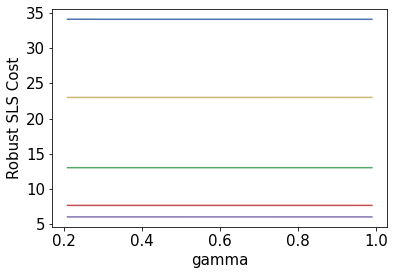

In [382]:
for i in range(5):
    plt.plot(gammas[4:], robust_costs[i,4:])
plt.xlabel('gamma')
plt.ylabel('Robust SLS Cost')

## Robust Control Scratch

In [216]:
def print_np_matlab(x):
    print('[', end='')
    for row in x:
        for element in row:
            print(element, end=' ')
        print('', end=';')
    print('];')

In [256]:
N = 4
degree = 3
T = 10
G, S, A, B, Q, R = environment._generate_env(N, degree, 'numerical')
_, cost_n, Phi_x, Phi_u, phi_x, phi_u = gf_synth(Q, R, A, B, S, T)

gamma = 0.98
#_, cost_r, Phi_xr, Phi_ur, _, _, Hbar = robust.robust_nominal_SLS(Q, R, A, B, S, T, gamma, N-1)
_, cost_r, Phi_xr, Phi_ur, _, _, Hbar = robust.robust_projection(Phi_x, Phi_u, A, B, S, T, gamma, N-1)

In [257]:
A_x, B_x, C_x, C_u, D_u = achieved_Phi(A, B, Phi_xr, Phi_ur, T)
print('H2 norm of achieved Px is:', H2norm(A_x, B_x, C_x))
print('H2 norm of achieved Pu is:', H2norm(A_x, B_x, C_u))
achieved_cost = np.sqrt(H2norm(A_x, B_x, C_x)**2 + H2norm(A_x, B_x, C_u)**2)
print('achieved cost is', achieved_cost)
print('upper bound is', cost_r / (1-gamma))
print('optimal cost is', cost_n)

H2 norm of achieved Px is: 2.394199221042228
H2 norm of achieved Pu is: 0.8846006733174238
achieved cost is 2.5523926542115047
upper bound is 28.193149092735357
optimal cost is 2.4348606031049016


In [241]:
print('A=', end=' ');print_np_matlab(A)
print('B=', end=' ');print_np_matlab(B)

# Print Phi_x from robust synthesis
print('Px1=', end=' ');print_np_matlab(Phi_xr[0:4])
print('Px2=', end=' ');print_np_matlab(Phi_xr[4:8])
print('Px3=', end=' ');print_np_matlab(Phi_xr[8:12])

# Print Phi_u from robust synthesis
print('Pu1=', end=' ');print_np_matlab(Phi_ur[0:4])
print('Pu2=', end=' ');print_np_matlab(Phi_ur[4:8])
print('Pu3=', end=' ');print_np_matlab(Phi_ur[8:12])

print('''Px = minreal(Px1/z + Px2/z^2 + Px3/z^3);
Pu = minreal(Pu1/z + Pu2/z^2 + Pu3/z^3);
Delta = minreal(z*Px - A*Px - B*Pu - eye(4));
hinfnorm(Delta)''')

A= [0.9381477199081755 -0.7885458992969012 1.0816990131413122 -0.3345101584817712 ;-0.7885458992969012 0.8909519100104188 0.36934766021992577 -0.09798095816187086 ;1.0816990131413122 0.36934766021992577 -0.7746127609754302 -0.6920209654085608 ;-0.33451015848177124 -0.09798095816187097 -0.6920209654085608 1.0035320458047021 ;];
B= [1.0904746561213339 -0.012019142815123198 0.5843301015182052 0.11380360248587287 ;-0.012019142815123179 0.9841220114780985 0.24695892737919187 0.4357462492303865 ;0.5843301015182052 0.24695892737919187 0.25428867025351 -0.04552560812387225 ;0.11380360248587287 0.4357462492303866 -0.04552560812387224 1.0991414741209615 ;];
Px1= [1.26538930534608 0.03575829228417977 0.09728440685972807 0.030246104025481935 ;0.03575829228417978 1.2055946091545295 0.02864958009326326 0.14008692882900908 ;0.0972844068597281 0.028649580093263256 1.1339450773328776 0.028620904709779203 ;0.030246104025481956 0.14008692882900906 0.028620904709779193 1.2335310527596763 ;];
Px2= [-0.6147

## Test whether the subspace constraints would be more numerically stable
not that is matters that much actually. This is just making sure that we can use this to further make the numerical properties a little bit better.

This boils down to testing how numerically good the SVD of the Vandermonde matrix is. If we can recover the vandermonde matrix after the SVD, it might be good?

In [924]:
N = 15
degree = 5
T = 10

G, S, A, B, Q, R = environment._generate_env(N, degree,'a')
_, _, Phi_x, Phi_u, _, _ = sls_synth(Q, R, A, B, S, T)

lbd_S, V = np.linalg.eigh(S)
Vand = np.vstack([np.power(lbd_S, i) for i in range(N)]).T
print('cond num is', np.linalg.cond(Vand))

successfully solved!
cond num is 1653619.70768386


In [925]:
# See how accurate svd is
[u, s, vh] = np.linalg.svd(Vand)
np.max(np.abs(u @ np.diag(s) @ vh - Vand))

2.886579864025407e-15

In [926]:
# Solve for the filter tap weights h for a given response PP
PP = Phi_x[N:2*N]
lbd_PP = np.diag(V.T @ PP @ V)
h_lstsq = np.linalg.lstsq(Vand, lbd_PP, rcond=None)[0]
h_svd = np.linalg.pinv(Vand) @ lbd_PP

In [927]:
# Reconstruct lbd_S
print('the eigenvalues are reconstructed with error: {:.2e}'.format(np.max(np.abs(Vand @ h_svd - lbd_PP))))

the eigenvalues are reconstructed with error: 4.84e-11


In [928]:
# Reconstruct PP
PP_recon = np.sum([h_svd[i] * np.linalg.matrix_power(S, i) for i in range(N)], 0)
print('PP is reconstructed with l-inf error: {:.2e}'.format(np.max(np.abs(PP_recon - PP))))

PP is reconstructed with l-inf error: 6.95e-07


As we can see here, both PP and eig(PP) can be reconstructed with very small error. But in that case, where does the numerical problem come from??

## Visualize the numerical properties of different GSO's you can get

We are not using any spectral methods here really, so we are not limited to the Laplacian matrix. All that we need is that the GSO satisfy certain sparsity patterns. So here we try out a bunch of difference GSO's on the same topology and check
1) the eigenvalues of the GSO
2) condition number of Vandermonde matrix
3) determinant of Vandermonde matrix

In [24]:
num_env = 20
num_M = 10
N = 10
degree = 5
T = 10

cond_S = []
cond_M = []
det_S = []
det_M = []

for env in range(num_env):
    # Generate an environment
    G, S, A, B, Q, R = environment._generate_env(N, degree)
    pattern = (S == 0)
    
    # Compute the Vandermonde matrix for S
    lbd_S, _ = np.linalg.eigh(S)
    A = np.vstack([np.power(lbd_S, i) for i in range(N)]).T
    det_S.append(np.linalg.det(A))
    cond_S.append(np.linalg.cond(A))

    # Generate random matrices and set the corresponding entries to 0
    for _ in range(num_M):
        M = np.random.normal(0, 1, (N,N))
        M = M + M.T
        M[pattern] = 0
        M = M / np.max(np.abs(np.linalg.eigh(M)[0]))

        # Compute the Vandermonde matrix for M
        lbd_M, _ = np.linalg.eigh(M)
        A = np.vstack([np.power(lbd_M, i) for i in range(N)]).T
        det_M.append(np.linalg.det(A))
        cond_M.append(np.linalg.cond(A))

# Visualize the condition numbers
tick_x = [0.3, 1.3]
tick_l = ['Laplacian', 'Random']

plt.bar(tick_x, [np.mean(cond_S), np.mean(cond_M)], alpha=0.5)
plt.yscale('log')
plt.xticks(tick_x, tick_l)
plt.plot('Condition Number of the Vandermonde Matrix')
print('Laplacian cond mean is', np.mean(cond_S))
print('Random cond mean is', np.mean(cond_M))

# Visualize the determinants
plt.yscale('log')
plt.bar(tick_x, [np.mean(det_S), np.mean(det_M)], alpha=0.5)
plt.xticks(tick_x, tick_l)
plt.plot('Determinant of the Vandermonde Matrix')
print('Laplacian det mean is', np.mean(det_S))
print('Random det mean is', np.mean(det_M))

# Visualize how the condition number and determinants correlate
plt.xscale('log')
plt.yscale('log')
plt.scatter(cond_S, det_S)
plt.scatter(cond_M, det_M)
plt.xlabel('condition number')
plt.ylabel('determinant')